#### **Ejercicio:** ¿Regresión logística, bosque aleatorio o KNN?

**Elaborado por:** Fabian Villarreal Sosa

Utilizando el wine cultivars dataset de la sección de clasificación multiclase, tu tarea es utilizar modelos de regresión logística (uno frente a uno y uno frente a todos) y ajustarlos para su rendimiento óptimo. También debes intentar comparar el efecto de cuando intentas utilizar la regularización l1 y l2. Esta es una gran oportunidad para ver qué sucede cuando intentas ajustar un modelo. Después de hacer eso, intenta usar los modelos KNN, Bagged tree y Random Forest.

https://archive.ics.uci.edu/ml/machine-learning-databases/wine/

**Preguntas para pensar y responder**

Después de completar la tarea, responde las siguientes preguntas:

* ¿Qué modelo funcionó mejor?
* ¿Cuáles son las características más importantes de tus modelos? ¿Hay algún modelo que te haya gustado más y por qué?

In [236]:
# Librerias
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

from google.colab import drive

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

In [237]:
# Acceder a directorio en Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [238]:
# Determinar directorio
os.chdir('/content/drive/MyDrive/Coding Dojo/Datos')
os.getcwd()

'/content/drive/MyDrive/Coding Dojo/Datos'

In [239]:
# Datos
col_names = ['Class label', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 'Total phenols',
'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins','Color intensity', 'Hue', 'OD280/OD315 of diluted wines','Proline']

df = pd.read_csv('wine.data', header = None, names = col_names)
df.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [240]:
# Clases
df['Class label'].value_counts()

2    71
1    59
3    48
Name: Class label, dtype: int64

In [241]:
round(df['Class label'].value_counts() / df.shape[0] * 100, 2)

2    39.89
1    33.15
3    26.97
Name: Class label, dtype: float64

**Función a utilizar para estimar los modelos**

In [242]:
# Definicion de funcion
def model_class(model, X_train, X_test, y_train, y_test, method):
  np.random.seed(2731) # seed

  # Estimation
  model.fit(X_train, y_train)
  
  # Prediction
  df_train_yhat=model.predict(X_train)
  df_test_yhat=model.predict(X_test)

  # Metrics
  DeterCoef_train=model.score(X_train, y_train)
  DeterCoef_test=model.score(X_test, y_test)

  RMSE_train=np.sqrt(metrics.mean_squared_error(y_train, df_train_yhat))
  RMSE_test=np.sqrt(metrics.mean_squared_error(y_test, df_test_yhat))

  # Results
  print(f'\nModel Report\n{method}\n')
  
  print(f'Determination Coefficient (Train): {DeterCoef_train:.4f}')
  print(f'Determination Coefficient (Test): {DeterCoef_test:.4f}')

  print(f'RMSE (Train): {RMSE_train:.4f}')
  print(f'RMSE (Test): {RMSE_test:.4f}') 

In [243]:
# Matriz de caracteristicas y variable dependiente
X = df.loc[:, df.columns[(df.columns != 'Class label')]]
y = df.loc[:, 'Class label'].values

print('X dimensions:', X.shape)
print('y dimensions:', y.shape)

X dimensions: (178, 13)
y dimensions: (178,)


In [244]:
# Dividir en conjuntos de prueba y entrenamiento
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.3,
                                                    random_state = 0,
                                                    stratify = y) # Estratificar en funcion de y

In [245]:
# Estandarizar para el uso en los modelos de regresion logistica y KNN
X_std_train = X_train
X_std_test = X_test

In [246]:
# Estandarizar datos
scaler = StandardScaler()
# Ajustar con base en el conjunto de entrenamiento
scaler.fit(X_std_train)
# Aplicar la transformacion a los conjuntos de entrenamiento y prueba
X_std_train = scaler.transform(X_std_train)
X_std_test = scaler.transform(X_std_test)

### **Logistic Regression**

Se utiliza la funcion 'GridSearchCV' de scikit-learn para determinar la los valores u opciones para algunos parámetros.

In [247]:
# List of values to test the parameter n_estimators
C_range = [1] + list(range(10, 1010, 10))
np.array(C_range)

array([   1,   10,   20,   30,   40,   50,   60,   70,   80,   90,  100,
        110,  120,  130,  140,  150,  160,  170,  180,  190,  200,  210,
        220,  230,  240,  250,  260,  270,  280,  290,  300,  310,  320,
        330,  340,  350,  360,  370,  380,  390,  400,  410,  420,  430,
        440,  450,  460,  470,  480,  490,  500,  510,  520,  530,  540,
        550,  560,  570,  580,  590,  600,  610,  620,  630,  640,  650,
        660,  670,  680,  690,  700,  710,  720,  730,  740,  750,  760,
        770,  780,  790,  800,  810,  820,  830,  840,  850,  860,  870,
        880,  890,  900,  910,  920,  930,  940,  950,  960,  970,  980,
        990, 1000])

In [248]:
np.random.seed(2731)

# Modelo
log_regress = LogisticRegression(solver = 'liblinear', multi_class = 'ovr', max_iter = 1000)

# Parametros a evaluar en la funcion 'GridSearchCV'
parameters = {'C': C_range,
              'penalty': ['l1', 'l2']} 

# Determinacion y ejecucion del modelo
gridsearch_log_regress = GridSearchCV(log_regress, parameters, cv = 10);
gridsearch_log_regress.fit(X_std_train, y_train);

In [249]:
#Resultados
print(gridsearch_log_regress.best_params_)

C_opt=gridsearch_log_regress.best_params_['C']
penalty_opt=gridsearch_log_regress.best_params_['penalty']

{'C': 1, 'penalty': 'l2'}


Con base en estos resultados, se determinan los siguientes parametros: `C = 1` y `penalty = 'l2'`


In [250]:
# Lista de valores a probar para 'C'
scores = []
for c in C_range:
  log_regress = LogisticRegression(C = c, penalty = 'l2', solver = 'liblinear', multi_class = 'ovr', max_iter = 1000)
  log_regress.fit(X_std_train, y_train)
  score = log_regress.score(X_std_test, y_test)
  scores.append(score)

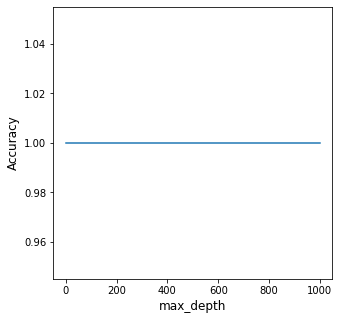

In [251]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (5, 5))
axes.plot(C_range, scores)
axes.set_xlabel('max_depth', fontsize = 12)
axes.set_ylabel('Accuracy', fontsize = 12);

In [252]:
max_value=max(scores)
max_index=scores.index(max_value)

print(scores)
print(max_value)
print(max_index)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
1.0
0


In [253]:
# Lista de valores a probar para 'penalty'
scores = []
for pen in ['l1', 'l2']:
  log_regress = LogisticRegression(C = C_opt, penalty = pen, solver = 'liblinear', multi_class = 'ovr', max_iter = 1000)
  log_regress.fit(X_std_train, y_train)
  score = log_regress.score(X_std_test, y_test)
  scores.append(score)

In [254]:
max_value=max(scores)
max_index=scores.index(max_value)

list(zip(['l1', 'l2'], scores))

[('l1', 1.0), ('l2', 1.0)]

**Estimación**

In [255]:
# Estimacion
log_regress = LogisticRegression(C = C_opt, 
                                 penalty = penalty_opt, 
                                 solver = 'liblinear', 
                                 multi_class = 'ovr', 
                                 max_iter = 1000)

model_class(log_regress, X_std_train, X_std_test, y_train, y_test, 'Logistic Regression: OvR, L2')


Model Report
Logistic Regression: OvR, L2

Determination Coefficient (Train): 0.9919
Determination Coefficient (Test): 1.0000
RMSE (Train): 0.0898
RMSE (Test): 0.0000


### **KNN**

In [256]:
# Encontrar cantidad optima de k y el peso a utilizar 

np.random.seed(2731) # seed

# Modelo
knn_class = KNeighborsClassifier()

# Parametros a evaluar en la funcion 'GridSearchCV'
parameters = {'n_neighbors': range(2, 40, 1),
              'weights': ['uniform', 'distance']} 

# Determinacion y ejecucion del modelo
gridsearch_knn_class = GridSearchCV(knn_class, parameters, cv = 10)
gridsearch_knn_class.fit(X_std_train, y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(2, 40),
                         'weights': ['uniform', 'distance']})

In [257]:
# Resultado
print(gridsearch_knn_class.best_params_)

k_opt = gridsearch_knn_class.best_params_['n_neighbors']
w_opt = gridsearch_knn_class.best_params_['weights']

{'n_neighbors': 34, 'weights': 'distance'}


**Estimación**

In [258]:
# Estimacion
knn_class = KNeighborsClassifier(n_neighbors = k_opt, 
                                 weights = w_opt)

model_class(knn_class, X_std_train, X_std_test, y_train, y_test, 'KNeighbors Classifier')


Model Report
KNeighbors Classifier

Determination Coefficient (Train): 1.0000
Determination Coefficient (Test): 0.9815
RMSE (Train): 0.0000
RMSE (Test): 0.1361


### **Bagged trees**

In [259]:
# Lista de valores para probar el parametro n_estimators
estimator_range = [1] + list(range(10, 210, 10))
np.array(estimator_range)

array([  1,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
       130, 140, 150, 160, 170, 180, 190, 200])

In [260]:
# Lista para almacenar los scores para cada valor de n_estimators
scores = []
for estimator in estimator_range:
  bag_class = BaggingClassifier(n_estimators = estimator, bootstrap = True, random_state = 2731)
  bag_class.fit(X_train, y_train)
  score = bag_class.score(X_test, y_test)
  scores.append(score)

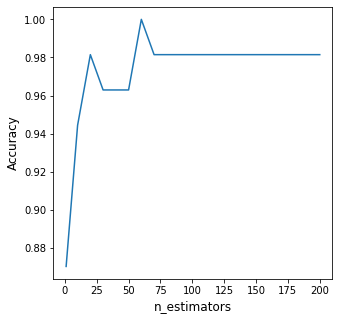

In [261]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (5, 5))
axes.plot(estimator_range, scores)
axes.set_xlabel('n_estimators', fontsize = 12)
axes.set_ylabel('Accuracy', fontsize = 12);

In [262]:
max_value=max(scores)
max_index=scores.index(max_value)

print(max_value)
print(max_index)
print(estimator_range[max_index])
# n_estimator = 60

1.0
6
60


In [263]:
# Estimacion 
bag_class = BaggingClassifier(n_estimators = 60, 
                                bootstrap = True,
                                random_state = 2731)

model_class(bag_class, X_train, X_test, y_train, y_test, 'Bagged Trees Classifier')


Model Report
Bagged Trees Classifier

Determination Coefficient (Train): 1.0000
Determination Coefficient (Test): 1.0000
RMSE (Train): 0.0000
RMSE (Test): 0.0000


### **Random Forest**

In [264]:
# Lista de valores para probar el parametro n_estimators
estimator_range = [1] + list(range(10, 210, 10))
np.array(estimator_range)

array([  1,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
       130, 140, 150, 160, 170, 180, 190, 200])

In [265]:
# Lista para almacenar los scores para cada valor de n_estimators
scores = []
for estimator in estimator_range:
  rfor_class = RandomForestClassifier(n_estimators = estimator, bootstrap = True, random_state = 2731)
  rfor_class.fit(X_train, y_train)
  score = rfor_class.score(X_test, y_test)
  scores.append(score)

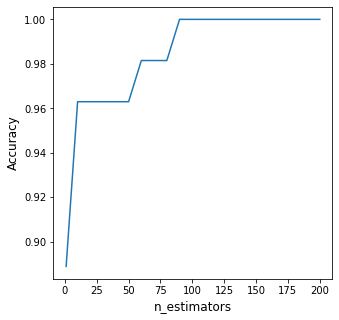

In [266]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (5, 5))
axes.plot(estimator_range, scores)
axes.set_xlabel('n_estimators', fontsize = 12)
axes.set_ylabel('Accuracy', fontsize = 12);

In [267]:
max_value=max(scores)
max_index=scores.index(max_value)

print(max_value)
print(max_index)
print(estimator_range[max_index])
# n_estimator = 90

1.0
9
90


In [268]:
# Estimacion 
rfor_class = RandomForestClassifier(n_estimators = 90,
                                    bootstrap = True,
                                    random_state = 2731)

model_class(rfor_class, X_train, X_test, y_train, y_test, 'Random Forest Classifier')


Model Report
Random Forest Classifier

Determination Coefficient (Train): 1.0000
Determination Coefficient (Test): 1.0000
RMSE (Train): 0.0000
RMSE (Test): 0.0000


#### **Resumen**

In [269]:
model_class(log_regress, X_std_train, X_std_test, y_train, y_test, 'Logistic Regression: OvR, L2')


Model Report
Logistic Regression: OvR, L2

Determination Coefficient (Train): 0.9919
Determination Coefficient (Test): 1.0000
RMSE (Train): 0.0898
RMSE (Test): 0.0000


In [270]:
model_class(knn_class, X_std_train, X_std_test, y_train, y_test, 'KNeighbors Classifier')


Model Report
KNeighbors Classifier

Determination Coefficient (Train): 1.0000
Determination Coefficient (Test): 0.9815
RMSE (Train): 0.0000
RMSE (Test): 0.1361


In [271]:
model_class(bag_class, X_train, X_test, y_train, y_test, 'Bagged Trees Classifier')


Model Report
Bagged Trees Classifier

Determination Coefficient (Train): 1.0000
Determination Coefficient (Test): 1.0000
RMSE (Train): 0.0000
RMSE (Test): 0.0000


In [272]:
model_class(rfor_class, X_train, X_test, y_train, y_test, 'Random Forest Classifier')


Model Report
Random Forest Classifier

Determination Coefficient (Train): 1.0000
Determination Coefficient (Test): 1.0000
RMSE (Train): 0.0000
RMSE (Test): 0.0000


En función de estos resultados, se opta por el modelo de Random Forest. Si bien los resultados son similares a los proporcionados por el modelo de Bagged Trees, se toma en consideración que en los Bagged trees puede haber una característica muy fuerte en tu conjunto de datos que sea muy predictiva. De esta forma, al usar Random Forest, se está tratando de descorrelacionar los árboles y así reducir la varianza del modelo

¿Qué modelo funcionó mejor?

In [273]:
# Se probaron distintas especificaciones dentro de cada uno de los modelos abordados: 
# Logistic Regression, KNN, Bagged Trees y Random Forest. 
# En función de estos resultados, se opta por el modelo de Random Forest. Si bien los resultados son 
# similares a los proporcionados por el modelo de Bagged Trees, se toma en consideración que en los 
# Bagged trees puede haber una característica muy fuerte en tu conjunto de datos que sea muy predictiva. 
# De esta forma, al usar Random Forest, se está tratando de descorrelacionar los árboles y así reducir la varianza del modelo

¿Cuáles son las características más importantes de tus modelos? ¿Hay algún modelo que te haya gustado más y por qué?

In [274]:
# ¿Hay algún modelo que te haya gustado más y por qué? Ver arriba

# ¿Hay algún modelo que te haya gustado más y por qué?

# Importancia de las caracteristicas
list(zip(X.columns, rfor_class.feature_importances_))

[('Alcohol', 0.12393991377441768),
 ('Malic acid', 0.02362421445601054),
 ('Ash', 0.013637076532402616),
 ('Alcalinity of ash', 0.021064400548206998),
 ('Magnesium', 0.03024554928262492),
 ('Total phenols', 0.0536007374118288),
 ('Flavanoids', 0.1374349838912618),
 ('Nonflavanoid phenols', 0.017960769901034193),
 ('Proanthocyanins', 0.017285828042297675),
 ('Color intensity', 0.15553911822577018),
 ('Hue', 0.07556042222448281),
 ('OD280/OD315 of diluted wines', 0.14267459940800628),
 ('Proline', 0.18743238630165548)]

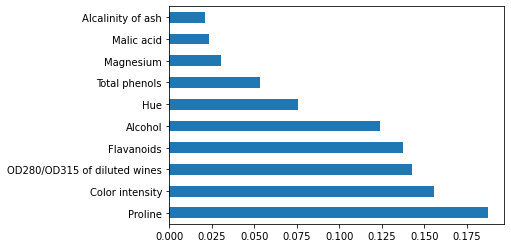

In [275]:
feat_importances = pd.Series(rfor_class.feature_importances_, index = X.columns)

# Grafico
feat_importances.nlargest(10).plot(kind = 'barh');